# 导出特征向量

In [6]:
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D
from keras.applications.resnet50 import ResNet50, decode_predictions
from keras.applications import *
import cv2, os, itertools
import numpy as np
from sklearn.utils import shuffle


In [115]:
TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'

train_dir = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR)]
# train_dog_dir = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
# train_cat_dir = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR) if 'cat' in i]
test_dir = [TEST_DIR + i for i in os.listdir(TEST_DIR)]

# train_dir = train_dir[:50]
# test_dir = test_dir[:50]
train_dir

['data/train/dog.8011.jpg',
 'data/train/cat.5077.jpg',
 'data/train/dog.7322.jpg',
 'data/train/cat.2718.jpg',
 'data/train/cat.10151.jpg',
 'data/train/cat.3406.jpg',
 'data/train/dog.1753.jpg',
 'data/train/cat.4369.jpg',
 'data/train/cat.7660.jpg',
 'data/train/dog.5535.jpg',
 'data/train/cat.8553.jpg',
 'data/train/cat.9895.jpg',
 'data/train/cat.1211.jpg',
 'data/train/dog.3144.jpg',
 'data/train/dog.775.jpg',
 'data/train/dog.11102.jpg',
 'data/train/cat.6218.jpg',
 'data/train/dog.11664.jpg',
 'data/train/dog.3622.jpg',
 'data/train/cat.1577.jpg',
 'data/train/cat.12020.jpg',
 'data/train/dog.5253.jpg',
 'data/train/cat.7106.jpg',
 'data/train/cat.8235.jpg',
 'data/train/cat.952.jpg',
 'data/train/dog.9469.jpg',
 'data/train/dog.1035.jpg',
 'data/train/cat.3360.jpg',
 'data/train/cat.11529.jpg',
 'data/train/cat.10637.jpg',
 'data/train/dog.6982.jpg',
 'data/train/dog.8777.jpg',
 'data/train/dog.7444.jpg',
 'data/train/cat.5711.jpg',
 'data/train/cat.946.jpg',
 'data/train/cat.

# save feature vector to file

In [4]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

concat_train_feature_vector = np.ndarray((len(train_dir), 2048 + 2048 + 512 + 512), dtype = np.float32)
concat_test_feature_vector = np.ndarray((len(test_dir), 2048 + 2048 + 512 + 512), dtype = np.float32)

def get_feature_vector_list(image_path_list, MODEL, input_size, preprocess_fun = None):
    inputs = Input(input_size)
    #注意: 预处理函数对于Xception和InceptionV3都是必须的, 否则会预测出错
    if preprocess_fun:
        inputs = Lambda(preprocess_fun)(inputs)
        
    #❓我的组合模型为什么错了
#     x = MODEL(input_tensor = inputs, include_top = False).output
#     outputs = GlobalAveragePooling2D()(x)
#     model = Model(inputs = inputs, outputs = outputs)

    #别人的正确模型
    base_model = MODEL(input_tensor = inputs, weights = 'imagenet', include_top = False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    #不修改的模型
#     model = MODEL(input_tensor = inputs, weights='imagenet')

    print('start {} prediction:'.format(base_model.name))
    feature_vector_list = []
    for i, image_path in enumerate(image_path_list):
        input_image = prepare_data(image_path, input_size)
        input_image = np.expand_dims(input_image, axis = 0)
        feature_vector = model.predict(input_image, verbose = 0)
        feature_vector_list.append(feature_vector)
        #显示进度条
        if i%(len(image_path_list)//100) == 0:
            print('>', end = '')
    print('finish {} prediction'.format(base_model.name))
    
    return feature_vector_list

        
def prepare_data(image_path, input_size):
    rows = input_size[0]
    cols = input_size[1]
    channels = input_size[2]
    data = np.ndarray(input_size, dtype = np.uint8)
    
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (rows, cols), interpolation = cv2.INTER_CUBIC)
    
    return image


def get_and_save_feature_vector():
    #ResNet50输出(1, 2048)
    ResNet50_train_feature_vector_list = get_feature_vector_list(train_dir, ResNet50, (224, 224, 3))
    #Xception输出(1, 2048)
    Xception_train_feature_vector_list = get_feature_vector_list(train_dir, Xception, (299, 299, 3), xception.preprocess_input)
    #TODO: 修正InceptionV3模型的错误使用
    # get_feature_vector(image_path, InceptionV3, (299, 299, 3), inception_v3.preprocess_input)
    #VGG16输出(1, 512)
    VGG16__train_feature_vector_list = get_feature_vector_list(train_dir, VGG16, (224, 224, 3))
    #VGG19输出(1, 512)
    VGG19__train_feature_vector_list = get_feature_vector_list(train_dir, VGG19, (224, 224, 3))
    for i in range(len(train_dir)):
        concat_train_feature_vector[i] = np.concatenate([ResNet50_train_feature_vector_list[i], 
                                                        Xception_train_feature_vector_list[i],
                                                        VGG16__train_feature_vector_list[i],
                                                        VGG19__train_feature_vector_list[i]], axis=1)
    
    ResNet50_test_feature_vector_list = get_feature_vector_list(test_dir, ResNet50, (224, 224, 3))
    Xception_test_feature_vector_list = get_feature_vector_list(test_dir, Xception, (299, 299, 3), xception.preprocess_input)
    VGG16__test_feature_vector_list = get_feature_vector_list(test_dir, VGG16, (224, 224, 3))
    VGG19__test_feature_vector_list = get_feature_vector_list(test_dir, VGG19, (224, 224, 3))
    for i in range(len(test_dir)):
        concat_test_feature_vector[i] = np.concatenate([ResNet50_test_feature_vector_list[i], 
                                                        Xception_test_feature_vector_list[i],
                                                        VGG16__test_feature_vector_list[i],
                                                        VGG19__test_feature_vector_list[i]], axis=1)
    
    np.savetxt("concat_train_feature_vector.npy", concat_train_feature_vector, delimiter = ',')
    np.savetxt("concat_test_feature_vector.npy", concat_test_feature_vector, delimiter = ',')
        
    return None


get_and_save_feature_vector() 
    

KeyboardInterrupt: 

# read feature vector from file

In [47]:
concat_test_feature_vector = np.loadtxt(open("concat_test_feature_vector.npy","rb"), delimiter=",").astype(np.float32)
concat_train_feature_vector = np.loadtxt(open("concat_train_feature_vector.npy","rb"), delimiter=",").astype(np.float32)

In [84]:
concat_train_feature_vector.shape

(25000, 5120)

In [97]:
concat_test_feature_vector2 = concat_test_feature_vector[:, :4096]
concat_train_feature_vector2 = concat_train_feature_vector[:, :4096]
concat_train_feature_vector2.shape

(25000, 4096)

data/train/dog.8011.jpg
data/train/cat.5077.jpg
data/train/dog.7322.jpg
data/train/cat.2718.jpg
data/train/cat.10151.jpg
data/train/cat.3406.jpg
data/train/dog.1753.jpg
data/train/cat.4369.jpg
data/train/cat.7660.jpg
data/train/dog.5535.jpg


array([1, 0, 1, 0, 0, 0, 1, 0, 0, 1])

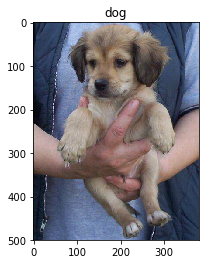

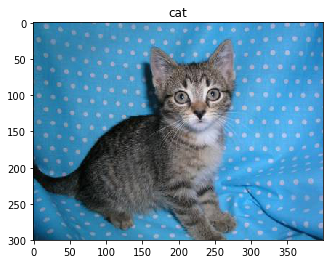

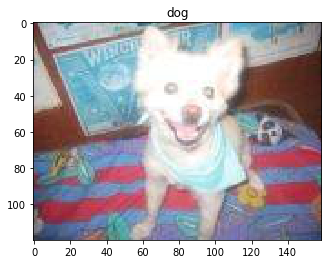

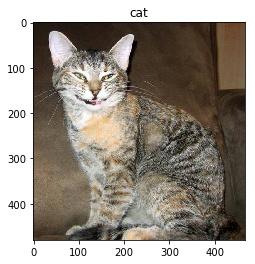

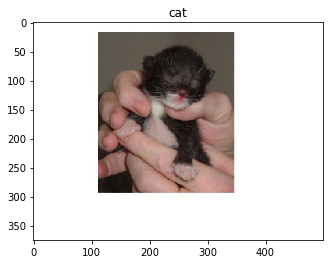

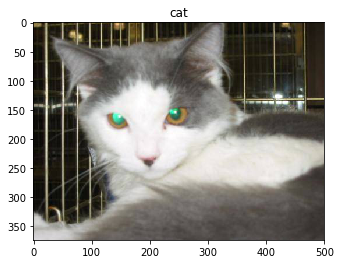

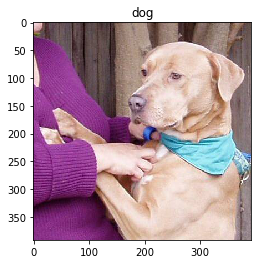

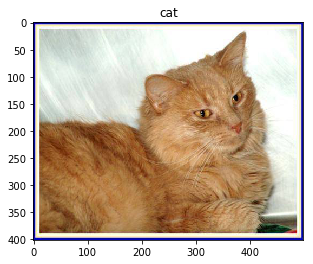

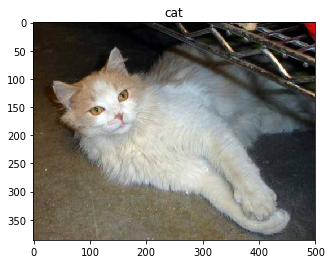

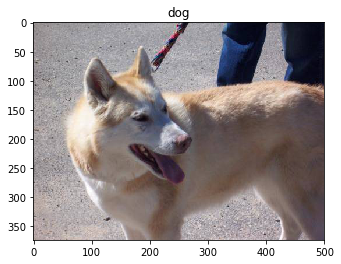

In [103]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

labels = []
for train_image_dir in train_dir[:10]:
    print(train_image_dir)
    if 'dog' in train_image_dir:
        labels.append(1)
        image_show = mpimg.imread(train_image_dir)
        plt.figure()
        plt.imshow(image_show)
        plt.title("dog")
    else:
        labels.append(0)
        
        image_show = mpimg.imread(train_image_dir)
        plt.figure()
        plt.imshow(image_show)
        plt.title("cat")
        
y_train = np.array(labels)

# x_train, y_train = shuffle(concat_train_feature_vector, y_train)
y_train

In [81]:
y_train.shape

(25000,)

# define new model

In [82]:
inputs = Input(shape = (x_train.shape[1], ))
x = Dropout(0.5)(inputs)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, nb_epoch=8, validation_split=0.2)
y_pre = model.predict(concat_test_feature_vector)

/anaconda3/envs/dog-project/lib/python3.5/site-packages/keras/engine/training.py:1393: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 20000 samples, validate on 5000 samples
Epoch 1/8
20000/20000 [==============================] - 1s - loss: 1.7156 - acc: 0.5008 - val_loss: 0.9054 - val_acc: 0.5018
Epoch 2/8
20000/20000 [==============================] - 1s - loss: 1.1927 - acc: 0.5027 - val_loss: 1.0401 - val_acc: 0.4898
Epoch 3/8
20000/20000 [==============================] - 1s - loss: 0.9786 - acc: 0.4998 - val_loss: 0.7960 - val_acc: 0.5066
Epoch 4/8
20000/20000 [==============================] - 1s - loss: 0.8912 - acc: 0.5086 - val_loss: 0.7253 - val_acc: 0.4972
Epoch 5/8
20000/20000 [==============================] - 0s - loss: 0.8486 - acc: 0.5133 - val_loss: 0.7807 - val_acc: 0.4906
Epoch 6/8
20000/20000 [==============================] - 0s - loss: 0.8337 - acc: 0.5125 - val_loss: 0.7197 - val_acc: 0.4950
Epoch 7/8
20000/20000 [==============================] - 0s - loss: 0.8113 - acc: 0.5226 - val_loss: 0.8547 - val_acc: 0.5076
Epoch 8/8
20000/20000 [==============================] - 0s - loss: 0

In [83]:
y_pre

array([[ 0.52981359],
       [ 0.28094026],
       [ 0.29968709],
       ..., 
       [ 0.34398863],
       [ 0.37511638],
       [ 0.34277579]], dtype=float32)